# Import Libraries

In [317]:
import cv2

In [318]:
import numpy
import numpy as np

In [319]:
import matplotlib.pyplot as plt

In [320]:
import skimage.feature as skim

In [ ]:
import sys

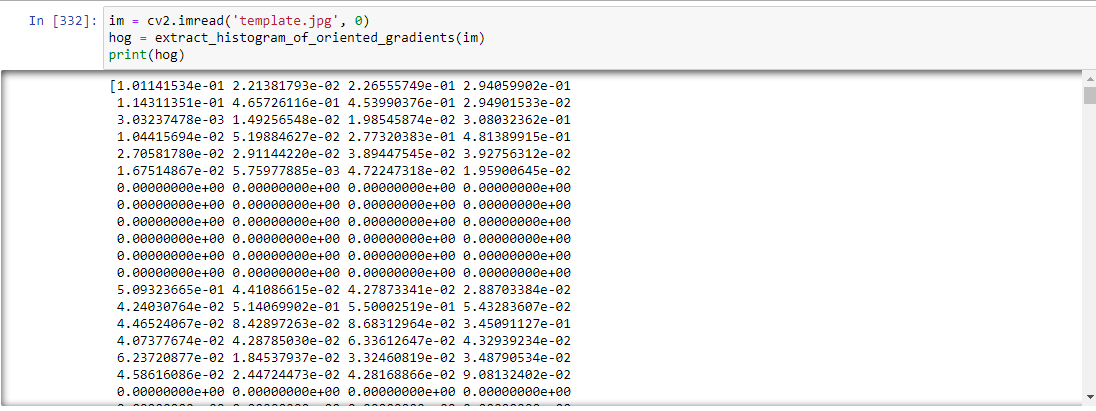

# Detailed Analysis about Histogram of Oriented Gradients

In [321]:
def sobel_filter():
    # Creating an Numpy array of 3x3 and naming the variable as filter x
    filter_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    # Creating an Numpy array of 3x3 and naming the variable as filter y
    filter_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    return filter_x, filter_y

In [322]:
sobelfilter()

(array([[ 1,  0, -1],
        [ 2,  0, -2],
        [ 1,  0, -1]]),
 array([[ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1]]))

In [323]:
def image_filtering(im, filter):
    #Printing an array of zeros with the same shape 
    im_filtered = np.zeros_like(im)
    #.flatten return a copy of the array collapsed into one dimension.
    filter_flattened = filter.flatten()
    height = len(im)
    width = len(im[0])
    #np.pad pads the numpy arrays
    im_padded = np.pad(im,1)

    for i in range(height):
        for j in range(width):
            im_window = im_padded[i:i+3,j:j+3].flatten()
            im_filtered[i][j] = np.dot(im_window, filter_flattened)

    return im_filtered


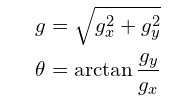

In [324]:
def magnitude_direction_gradient(im_dx, im_dy):
    height = len(im_dx)
    width = len(im_dy[0])
    #np.zeros_like return an array of zeros with the same shape and type as a given array.
    grad_mag = np.zeros_like(im_dx,dtype=np.float)
    grad_angle = np.zeros_like(im_dx,dtype=np.float)
    for i in range(height):
        #Applying the formula as listed in the above image
        grad_mag[i] = [np.linalg.norm([dX,dY]) for (dX,dY) in zip(im_dx[i],im_dy[i])]
        for j in range(width):
            dX = im_dx[i][j]
            dY = im_dy[i][j]
            if abs(dX) > 0.00001:
                grad_angle[i][j] = np.arctan(float(dY/dX)) + (np.pi/2)
            else:
                if dY < 0 and dX < 0:
                    grad_angle[i][j] = 0
                else:
                    grad_angle[i][j] = np.pi
    return grad_mag, grad_angle

In [325]:
def create_histogram(grad_mag, grad_angle, cell_size):
    #Defining the height, width, bins, x corner and the y corner
    height = len(grad_mag)
    width = len(grad_mag[0])
    nBins = 6
    x_corner = 0
    y_corner = 0
    ori_histo = np.zeros((int(height / cell_size), int(width / cell_size), nBins), dtype=float)
    #Applyint a while loop
    while (x_corner + cell_size) <= height:
        while (y_corner + cell_size) <= width:
            hist = np.zeros((6), dtype=float)
            magROI = grad_mag[x_corner:x_corner+cell_size, y_corner:y_corner+cell_size].flatten()
            angleROI = grad_angle[x_corner:x_corner+cell_size, y_corner:y_corner+cell_size].flatten()
            for i in range(cell_size*cell_size):
                angleInDeg = angleROI[i] * (180 / np.pi)
                if angleInDeg >=0 and angleInDeg < 30:
                    hist[0] += magROI[i]
                elif angleInDeg >=30 and angleInDeg < 60:
                    hist[1] += magROI[i]
                elif angleInDeg >=60 and angleInDeg < 90:
                    hist[2] += magROI[i]
                elif angleInDeg >=90 and angleInDeg < 120:
                    hist[3] += magROI[i]
                elif angleInDeg >=120 and angleInDeg < 150:
                    hist[4] += magROI[i]
                else:
                    hist[5] += magROI[i]
            ori_histo[int(x_corner/cell_size),int(y_corner/cell_size),:] = hist
            y_corner += cell_size
        x_corner += cell_size
        y_corner = 0
    return ori_histo

In [326]:
def block_normalization(ori_histo, block_size):
    x_window = 0
    y_window = 0
    height = len(ori_histo)
    width = len(ori_histo[0])
    ori_histo_normalized = np.zeros(((height-(block_size-1)), (width-(block_size-1)), (6*(block_size**2))), dtype=float)
    while x_window + block_size <= height:
        while y_window + block_size <= width:
            concatednatedHist = ori_histo[x_window:x_window + block_size, y_window:y_window + block_size,:].flatten()
            histNorm = np.sqrt(np.sum(np.square(concatednatedHist)) + 0.001)
            ori_histo_normalized[x_window,y_window,:] = [(h_i / histNorm) for h_i in concatednatedHist]
            y_window += block_size
        x_window += block_size
        y_window = 0
    return ori_histo_normalized

In [327]:
def extract_histogram_of_oriented_gradients(im):
    im = im.astype('float') / 255.0
    im = (im - np.min(im)) / np.max(im)
    x_filter, y_filter = sobel_filter()
    dx = image_filtering(im, x_filter)
    dy = image_filtering(im, y_filter)
    mag_matrix, angle_mat = magnitude_direction_gradient(dx, dy)
    histogramMat = create_histogram(mag_matrix, angle_mat, 8)
    hog_descriptors = block_normalization(histogramMat, 2)
    hog = hog_descriptors.flatten()
    #visualize_hog_each_block(im, hog, 8, 2)
    return hog

In [328]:
def visualize_hog_each_block(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  
    # controlling sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    # num_blocks_h x num_blocks_w x num_bins
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    # expand to same dims as histo_normalized
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  
    # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.show()

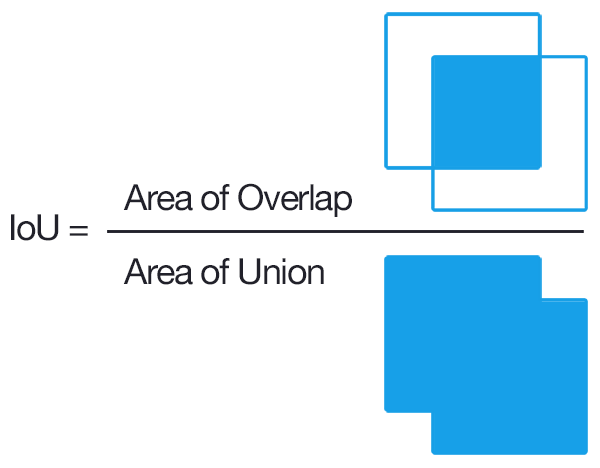

In [329]:
def iou(box1,box2, boxSize):
    sumOfAreas = 2*(boxSize**2)
    box_1 = [box1[0], box1[1], box1[0] + boxSize, box1[1] + boxSize]
    box_2 = [box2[0], box2[1], box2[0] + boxSize, box2[1] + boxSize]
    intersectionArea = (min(box_1[2],box_2[2]) - max(box_1[0], box_2[0])) * (min(box_1[3],box_2[3]) - max(box_1[1], box_2[1]))
    return float(intersectionArea / (sumOfAreas - intersectionArea))

In [360]:
def facedetection(I_target, I_template):
    template_HOG = extract_histogram_of_oriented_gradients(I_template)
    template_HOG = template_HOG - np.mean(template_HOG) 
    template_HOG_norm = np.linalg.norm(template_HOG)
    img_h, img_w = I_target.shape
    box_h, box_w = I_template.shape
    x = 0
    y = 0
    all_bounding_boxes = []
    while x + box_h <= img_h:
        print("Searching in row", x)
        while y + box_w <= img_w:
            img_window = I_target[x:x+box_h, y:y+box_w]
            img_HOG = extract_histogram_of_oriented_gradients(img_window)
            img_HOG = img_HOG - np.mean(img_HOG) # Normalize
            img_HOG_norm = np.linalg.norm(img_HOG)
            score = float(np.dot(template_HOG, img_HOG) / (template_HOG_norm*img_HOG_norm))
            all_bounding_boxes.append([y,x,score])
            # A stride of 3 is enough to produce a good result for the target. 
            y += 3
        x += 3
        y = 0
    print("Computing scores.")
    bounding_boxes = []
    all_bounding_boxes = sorted(list(all_bounding_boxes),key=lambda box: box[2], reverse=True)
    # Doing Thresholding
    thresholded_boxes = []
    for box in all_bounding_boxes:
        if box[2] >= 0.6: 
            thresholded_boxes.append(box)
    #Printing the Number of Boxes After Thresholding
    print("Number of boxes after thresholding: ", len(thresholded_boxes))
    # Applying Non Maximum Supression
    while thresholded_boxes != []:
        currBox = thresholded_boxes[0]
        bounding_boxes.append(currBox)
        toRemove = []
        for box in thresholded_boxes:
            if iou(currBox, box, box_w) >= 0.5:
                toRemove.append(box)
        for remBox in toRemove:
            thresholded_boxes.remove(remBox)
    return np.array(bounding_boxes)


In [361]:
def visualize_face_detection(I_target,bounding_boxes,box_size):

    hh,ww,cc=I_target.shape

    fimg=I_target.copy()
    # Defining the Range as per the shape of the bounding boxes
    for ii in range(bounding_boxes.shape[0]):
        # Defining the Bounding Boxes and applying the conditions
        x1 = bounding_boxes[ii,0]
        x2 = bounding_boxes[ii, 0] + box_size 
        y1 = bounding_boxes[ii, 1]
        y2 = bounding_boxes[ii, 1] + box_size

        if x1<0:
            x1=0
        if x1>ww-1:
            x1=ww-1
        if x2<0:
            x2=0
        if x2>ww-1:
            x2=ww-1
        if y1<0:
            y1=0
        if y1>hh-1:
            y1=hh-1
        if y2<0:
            y2=0
        if y2>hh-1:
            y2=hh-1
        # cv2.rectangle draws a rectangle on any image.
        fimg = cv2.rectangle(fimg, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 1)
        #cv2.putText() method is used to draw a text string on any image.
        cv2.putText(fimg, "%.2f"%bounding_boxes[ii,2], (int(x1)+1, int(y1)+2), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    plt.figure(3)
    plt.imshow(fimg, vmin=0, vmax=1)
    plt.savefig('output_face_detection.png')

In [362]:
im = cv2.imread('sampleinput.png', 0)
hog = extract_histogram_of_oriented_gradients(im)
print(hog)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40205477e-01
 5.43280737e-02 3.28748394e-01 1.42873737e-01 3.10540969e-03
 2.60634338e-02 1.29714074e-01 4.03917567e-01 2.22097741e-01
 0.00000000e+00 2.75150901e-04 1.66553452e-03 6.90143920e-01
 2.06363176e-04 6.87877253e-04 2.07986331e-02 1.24389345e-02
 6.46561530e-02 2.00482647e-01 3.86142632e-02 8.63478587e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.84893943e-01 2.74016861e-02 8.33797736e-03 1.68977657e-02
 8.78109222e-02 3.88455596e-01 2.64782962e-01 2.59415702e-02
 3.11950875e-02 3.45646388e-02 4.28386561e-02 6.01219240e-01
 1.58049709e-01 5.33643228e-02 1.07628410e-02 6.98309606e-02
 7.21812585e-02 2.069605

In [363]:
numpy.set_printoptions(threshold=sys.maxsize)

In [364]:
print(hog)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40205477e-01
 5.43280737e-02 3.28748394e-01 1.42873737e-01 3.10540969e-03
 2.60634338e-02 1.29714074e-01 4.03917567e-01 2.22097741e-01
 0.00000000e+00 2.75150901e-04 1.66553452e-03 6.90143920e-01
 2.06363176e-04 6.87877253e-04 2.07986331e-02 1.24389345e-02
 6.46561530e-02 2.00482647e-01 3.86142632e-02 8.63478587e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.84893943e-01 2.74016861e-02 8.33797736e-03 1.68977657e-02
 8.78109222e-02 3.88455596e-01 2.64782962e-01 2.59415702e-02
 3.11950875e-02 3.45646388e-02 4.28386561e-02 6.01219240e-01
 1.58049709e-01 5.33643228e-02 1.07628410e-02 6.98309606e-02
 7.21812585e-02 2.069605

Searching in row 0
Searching in row 3
Searching in row 6
Searching in row 9
Searching in row 12
Searching in row 15
Searching in row 18
Searching in row 21
Searching in row 24
Searching in row 27
Searching in row 30
Searching in row 33
Searching in row 36
Searching in row 39
Searching in row 42
Searching in row 45
Searching in row 48
Searching in row 51
Searching in row 54
Searching in row 57
Searching in row 60
Searching in row 63
Searching in row 66
Searching in row 69
Searching in row 72
Searching in row 75
Searching in row 78
Searching in row 81
Searching in row 84
Computing scores.
Number of boxes after thresholding:  60


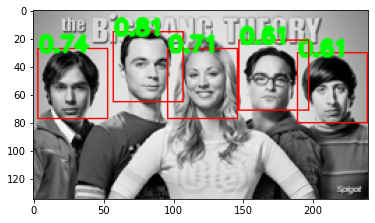

In [366]:
I_target= cv2.imread('First.png', 0)
I_template = cv2.imread('sampleinput.png', 0)
bounding_boxes=facedetection(I_target, I_template)
I_target_c= cv2.imread('First.png')
visualize_face_detection(I_target_c, bounding_boxes, I_template.shape[0])